# Sankey diagram

### 3.11.2021
### status: In progress

### Jiří Zelenka

https://github.com/JirkaZelenka/ # ...

---------------------------------------------------------------------------------------

## Popis projektu
* **Motivace:** Připravit interaktivní a intuitivní **Sankey diagram** ke zobrazení přesunů zaměstnatnců  - odchody, změny "skupiny", aj., v průběhu času.
* **Očekávání:** Jsme schopni zobrazit různá časová období a porovnat je. Můžeme si plně customizovat grafy. Vysoká interaktivita a přehlednost. Procenta i absolutní hodnoty.
* **Přístup:** Využití package **PLOTLY** pro vizualizace, dále Tlačítka a Dropdowny a další funkcionality grafů.

## Cíle
1) Vytvoření jednoduchých dummy dat
2) Vytvoření základního diagramu
3) Zapojení přídavných vlastností jako tlačítka, dropdown listy, aj.
4) Příprava dat pro využití časových filtrů
5) Export grafu, propojení s JDBC, jiné...?
6) Nice to have: Indikace, zda se mezi danými obdobími něco změnilo i když to graf nezachycuje: A (->B->) A

## Užitečné odkazy:

https://plotly.com/python/sankey-diagram/     # pozice nodů

https://www.youtube.com/watch?v=_jqrlvDVfls   # příklad 1

https://www.kaggle.com/jrmistry/plotly-how-to-change-plot-data-using-dropdowns   # příklad 2 - filtrování dat, ale jen pro překrývající se scatterploty, ne Sankey

https://github.com/plotly/plotly.py/issues/2508   # troubleshooting zobrazování, viz Import packagů

https://www.tutorialspoint.com/plotly/plotly_slider_control.htm  # slider TBD


---------------------------------------------------------------------------------------

## Import packagů

In [4]:
## Basic

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
#------------------------------------------------
## PLOTLY
import plotly.graph_objects as go

# MAGIE která řeší prádzné grafy !!!
import plotly.io as pio
pio.renderers.default = "iframe"

## Příklad 1

* interaktivní (jde přesouvat)
* setting barev a skupin plně měnitelný
* jdou přidělat tlačítka na filtry, třeba na datumy

<div>
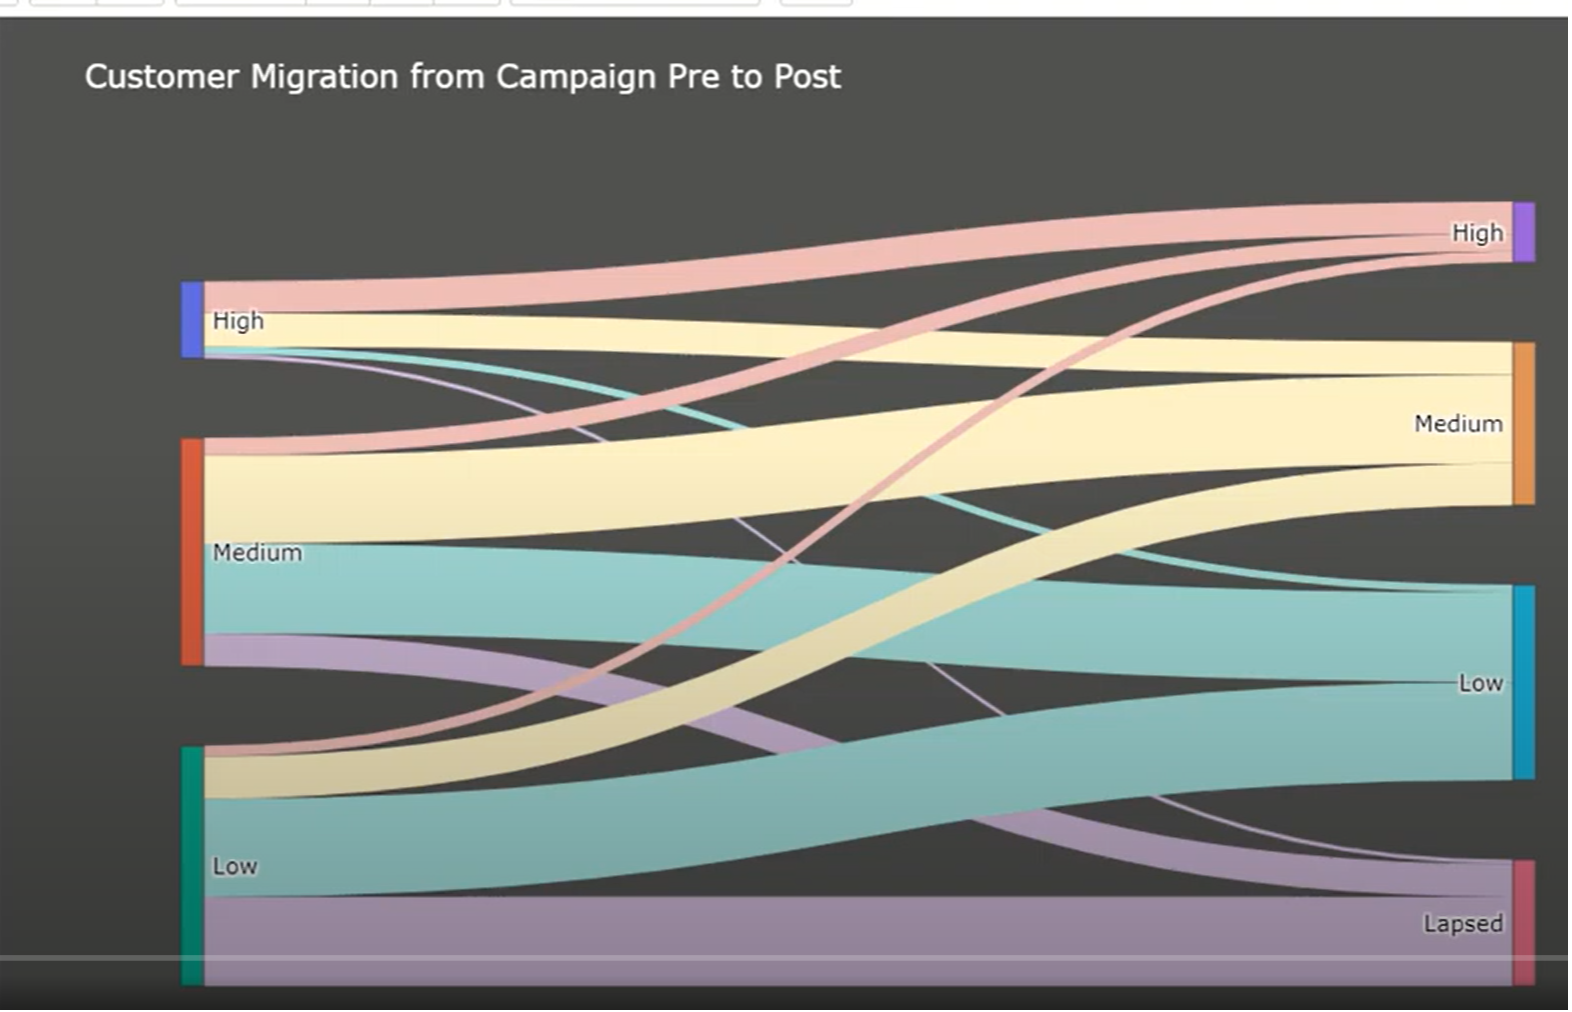
</div>

In [39]:
## DUMMY DATA

label = ["High", "Medium", "Low", "High", "Medium", "Low"]
source = [0,0,0,1,1,1,2,2,2]
target = [3,4,5,3,4,5,3,4,5]
value = [548,571,129,303,1513,1537,189,722,1684]

## Takto vzniknou tři sloupce: A1, A, B1, B2, C1, C2
# jde jen o to vypsat všechny vazby S->T
# source = [0, 1, 0, 2, 3, 3],
# target = [2, 3, 3, 4, 4, 5],

color_link = ["#f4f809", "#e25d53", "#f44336",
    "#8fce00", "#f4f809", "#e25d53", 
    "#5af436", "#8fce00", "#f4f809"]


# RED = zhoršení o 2 = f44336
# L.red = zhorešení o 1 = e25d53
# Green = zlepšení o 2 = 5af436
# L. green = zlepšení o 1 = 8fce00
# Yellow = stejné = f4f809

link = dict(source = source, target = target, value = value, color = color_link)
node = dict(label = label, pad = 35, thickness = 10)
data = go.Sankey(link = link, node = node)


In [42]:
fig = go.Figure(data)

fig.update_layout(
    hovermode = "x",   ## ????
    title = "Customer Migration",
    font=dict(size = 10, color = "white"),
    paper_bgcolor = "#51504f",
    width=1200, height=600)   ## přidáno extra, velikost grafu


fig.show()

# Přidání filtrování Values

**Pozn:** po vygenrování grafu je potřeba nehýbat objekty, ale vybrat jakékoliv datum, pak se vše srovná

**Pozn:** Když chybí data v některé kategorii (stačí jen na "jedné straně"), tak pak se graf trochu pomíchá kvůli souřadnicím nodů

### DUMMY DATA + Preprocessing

In [168]:
# Co řádek to zákazník a jeho měnící se stav, repsektive sloupec je stav všech 10 zákazníků v dané době

dummies = pd.DataFrame({
    'Date_1': ["High", "Medium", "Medium", "Non-C", "High", "Medium", "Non-C", "High", "Low", "Medium", "High", "Medium", "Non-C", "High", "Low", "Medium","Medium", "Medium", "Non-C", "High"],
    'Date_2':["Medium", "High", "Medium", "Low", "High", "Medium", "Non-C", "High", "Low", "High", "Medium", "High", "Medium", "Low", "Non-C", "High", "Low", "High", "Medium", "High"],
    'Date_3': ["Low", "Medium", "Low", "Low", "High", "Medium", "Low", "High", "Medium", "Medium", "Low", "Medium", "Low", "Low", "High", "Medium","Low", "Medium", "Non-C", "Low"],
    'Date_4': ["High", "Low", "Medium", "Medium", "High", "Medium", "High", "High", "Low", "High", "High", "Low", "Medium", "Medium", "High", "Medium", "High", "High", "Low", "Non-C"], })

print(dummies)

    Date_1  Date_2  Date_3  Date_4
0     High  Medium     Low    High
1   Medium    High  Medium     Low
2   Medium  Medium     Low  Medium
3    Non-C     Low     Low  Medium
4     High    High    High    High
5   Medium  Medium  Medium  Medium
6    Non-C   Non-C     Low    High
7     High    High    High    High
8      Low     Low  Medium     Low
9   Medium    High  Medium    High
10    High  Medium     Low    High
11  Medium    High  Medium     Low
12   Non-C  Medium     Low  Medium
13    High     Low     Low  Medium
14     Low   Non-C    High    High
15  Medium    High  Medium  Medium
16  Medium     Low     Low    High
17  Medium    High  Medium    High
18   Non-C  Medium   Non-C     Low
19    High    High     Low   Non-C


In [169]:
def grouping(df):
    """
    Input: jakýkoliv df, kde sloupečky jsou datumy seřazené zleva od nejstaršího,
            a kde jsou vypsané hodnoty pro dané customery v daném období.
    Output: Nový df, kde sloupečky jsou všechny kombinace datumů vždy starší-novější,
            a kde je 16 řádků (4x4 možností) přechodů mezi skupinami v daném období (bez ohledu na to co se dělo mezitím).
            Výsledný tvar je převedení df na dictionary of lists, což sedí jako input pro go.Sankey()
    """
    
    new_columns = []
    for i in range(len(df.columns)-1):
        #print("i is equal " + str(i))
        for j in range(i+1,len(df.columns)):
            #print("j is equal " + str(j))
            new_columns.append(str(df.columns[i]+ "-" +str(df.columns[j])))
    #print(new_columns)

    combinations = ["HH","HM","HL","HN","MH","MM","ML","MN","LH","LM","LL","LN","NH","NM","NL","NN"]
    
    data =  pd.DataFrame(columns = new_columns, index = combinations)   ## hezký, prázdný dataset
    #print(data)
    
    # pro každý sloupec splitni název sloupce pomocí "-" a použij jeho půlky
    for column in new_columns:
        p1, p2 = column.split("-")[0], column.split("-")[1]
        
        # data = nový dataset, df = původní       
        data[column].loc["HH"] = len(df[(df[p1] == "High") & (df[p2] == "High")])
        data[column].loc["HM"] = len(df[(df[p1] == "High") & (df[p2] == "Medium")])
        data[column].loc["HL"] = len(df[(df[p1] == "High") & (df[p2] == "Low")])
        data[column].loc["HN"] = len(df[(df[p1] == "High") & (df[p2] == "Non-C")])
        data[column].loc["MH"] = len(df[(df[p1] == "Medium") & (df[p2] == "High")])
        data[column].loc["MM"] = len(df[(df[p1] == "Medium") & (df[p2] == "Medium")])
        data[column].loc["ML"] = len(df[(df[p1] == "Medium") & (df[p2] == "Low")])
        data[column].loc["MN"] = len(df[(df[p1] == "Medium") & (df[p2] == "Non-C")])
        data[column].loc["LH"] = len(df[(df[p1] == "Low") & (df[p2] == "High")])
        data[column].loc["LM"] = len(df[(df[p1] == "Low") & (df[p2] == "Medium")])
        data[column].loc["LL"] = len(df[(df[p1] == "Low") & (df[p2] == "Low")])
        data[column].loc["LN"] = len(df[(df[p1] == "Low") & (df[p2] == "Non-C")])
        data[column].loc["NH"] = len(df[(df[p1] == "Non-C") & (df[p2] == "High")])
        data[column].loc["NM"] = len(df[(df[p1] == "Non-C") & (df[p2] == "Medium")])
        data[column].loc["NL"] = len(df[(df[p1] == "Non-C") & (df[p2] == "Low")])
        data[column].loc["NN"] = len(df[(df[p1] == "Non-C") & (df[p2] == "Non-C")])
        
    return(data.to_dict(orient="list"))  # vrací se dictionary of lists namísto df, to odpovídá inputu do Sankey
    
grouping(dummies)

{'Date_1-Date_2': [3, 2, 1, 0, 5, 2, 1, 0, 0, 0, 1, 1, 0, 2, 1, 1],
 'Date_1-Date_3': [2, 0, 4, 0, 0, 6, 2, 0, 1, 1, 0, 0, 0, 0, 3, 1],
 'Date_1-Date_4': [4, 1, 0, 1, 3, 3, 2, 0, 1, 0, 1, 0, 1, 2, 1, 0],
 'Date_2-Date_3': [2, 5, 1, 0, 0, 1, 4, 1, 0, 1, 3, 0, 1, 0, 1, 0],
 'Date_2-Date_4': [4, 1, 2, 1, 2, 3, 1, 0, 1, 2, 1, 0, 2, 0, 0, 0],
 'Date_3-Date_4': [3, 0, 0, 0, 2, 2, 3, 0, 4, 4, 0, 1, 0, 0, 1, 0]}

### Příprava grafu, Vazby, Barvy, Umístění nodů

In [170]:
## obarvování 
# a) podle toho, jestli je to zhoršení nebo zlepšení (ale to je vidět podle sklon nahoru/dolu)
# b) podle toho kam to jde, např všichni co jdou do medium jsou žlutí
# c) podle velikosti proudu? ale to je docela hard a možná zbytečné, protože to je taky vidět

In [171]:


label = ["High", "Medium", "Low","Non-customer", "High", "Medium", "Low", "Non-customer"]  #vazba Non-C -> Non-C existuje, když je to historie zatím nezačatého customera
source = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
target = [4,5,6,7,4,5,6,7,4,5,6,7,4,5,6,7]

## Získávání dat z matice s daty
values = grouping(dummies)


# obarvování b) podle cíle:
red = "#f44336"
yellow = "#f4f809"
green = "#5af436"
gray = "#87877c"

color_link = [green, yellow, red , gray,
              green, yellow, red , gray,
              green, yellow, red , gray,
              green, yellow, red , gray ]

link = dict(source = source, target = target, value = value, color = color_link)
node = dict(label = label,
            x = [0.1, 0.1, 0.1, 0.1, 0.9, 0.9, 0.9, 0.9],         # Přidáno extra - umístění nodů, jinak se řadí podle objemu !
            y = [0.05, 0.35, 0.65, 0.95, 0.05, 0.35, 0.65, 0.95],
            pad = 35, thickness = 10)


In [185]:
fig = go.Figure(go.Sankey(link = link, node = node))   #fig = go.Figure() vygeneruje nový plot


# Nefunkční verze, nelze narozdíl od go.Scatter() generovat vícero grafů Sankey "přes sebe" a pak si zobrazovat jen některé
"""
for x in values:
    link_custom = dict(source = source, target = target, value = x, color = color_link)  

    fig.add_trace(
        go.Figure(go.Sankey(link = link_custom, node = node)))
"""


fig.update_layout(
    hovermode = "x",   ## ????
    title = "Customer Migration",
    font=dict(size = 10, color = "white"),
    paper_bgcolor = "#51504f",
    width=1200, height=600)   ## přidáno extra, velikost grafu


fig.update_layout(
    updatemenus=[go.layout.Updatemenu(
        active=0,
        buttons=list(
            
            # Label tlačítka (resp později kombinace dvou tlačítek, nebo start tlačítko + slider) definguje jméno sloupce, resp list v dictionary, který se použije do values
            # pozn: do ARGS dict: nejde skoro nic vkládat ani odkazovat na label...
            
            [dict(label = 'Date_1-Date_2',
                  method = 'update',
                  args = [{'link': dict(source = source, target = target, value = values['Date_1-Date_2'], color = color_link) },
                          {'title': 'All',
                           'showlegend':True}]),
             dict(label = 'Date_1-Date_3',
                  method = 'update',
                  args = [{'link': dict(source = source, target = target, value = values['Date_1-Date_3'], color = color_link) },
                          {'title': 'Date1',
                           'showlegend':True}]),         
             dict(label = 'Date_1-Date_4',
                  method = 'update',
                  args = [{'link': dict(source = source, target = target, value = values['Date_1-Date_4'], color = color_link) },
                          {'title': 'Date1',
                           'showlegend':True}]), 
             dict(label = 'Date_2-Date_3',
                  method = 'update',
                  args = [{'link': dict(source = source, target = target, value = values['Date_2-Date_3'], color = color_link) },
                          {'title': 'Date1',
                           'showlegend':True}]), 
             dict(label = 'Date_2-Date_4',
                  method = 'update',
                  args = [{'link': dict(source = source, target = target, value = values['Date_2-Date_4'], color = color_link) },
                          {'title': 'Date1',
                           'showlegend':True}]), 
             dict(label = 'Date_3-Date_4',
                  method = 'update',
                  args = [{'link': dict(source = source, target = target, value = values['Date_3-Date_4'], color = color_link) }, 
                          {'title': 'Date1',
                           'showlegend':True}]),              
            ] ) ) ] ) 



fig.show()

# TO BE DONE:

* zobrazit spolu s hodnotami i procenta 

* Datumy nastavovat jako jako kombinace dvou tlačítek, nebo tlačítko + slider (ale hodnoty pořád musí být předpočítané pro kombinace)

* Napojení na databáze